# Evaluating Turbulence and Systematic Risk of Financial Markets

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
from tqdm import tqdm

import yfinance as yf

## 1. Fetch data (returns of all assets over entire history)

### Historical data

#### Australian Dollar

In [2]:
aud = yf.Ticker("AUDUSD=X")

# aud.info
aud_history = aud.history(period='10y', interval='1wk')
aud_history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-05-14,0.982801,0.985416,0.981932,0.982898,0,0,0
2012-05-21,0.983768,0.993937,0.970685,0.982318,0,0,0
2012-05-28,0.981547,0.989903,0.958497,0.965997,0,0,0
2012-06-04,0.964599,1.000300,0.963206,0.998403,0,0,0
2012-06-11,0.998403,1.013366,0.986777,1.011225,0,0,0
...,...,...,...,...,...,...,...
2022-04-25,0.723694,0.723338,0.705570,0.710884,0,0,0
2022-05-02,0.706539,0.726528,0.703408,0.712100,0,0,0
2022-05-09,0.704700,0.705189,0.684470,0.687191,0,0,0


/Users/tom/opt/miniconda3/envs/ThesisEnv/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


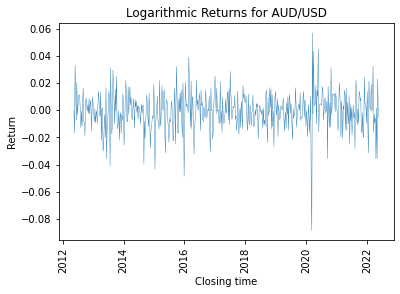

In [3]:
# computing/plotting returns
aud_log_returns = (np.log(aud_history.Close) - np.log(aud_history.Close.shift(1))).shift(-1)
aud_log_returns.dropna(inplace=True)

plt.plot(aud_log_returns, linewidth=0.4)
plt.xlabel('Closing time')
plt.ylabel('Return')
plt.title(f'Logarithmic Returns for AUD/USD')
plt.xticks(rotation=90)
plt.show()

#### US Dollar Index
USDX proportions:
- EUR = 57.6\%
- JPY = 13.6\%
- GBP = 11.9\%
- CAD = 9.1\%
- SEK = 4.2\%
- CHF = 3.6\%

In [193]:
class USDX:
    def __init__(self, assets=None):
        self.assets = assets
        self.turbulence = pd.Series([], dtype='float64')
        self.all_returns = pd.DataFrame()
        self.returns_now = pd.Series([], dtype='float64')
        self.now = ""
        self.returns_history = pd.DataFrame()

        if self.assets is not None and len(self.assets) > 0:
            self.fetch_returns()


    def fetch_returns(self, period='10y', interval='1wk'):
        # fetching log returns
        returns_dict = {}

        for asset in self.assets:
            # fetch closing values
            pair = f"{asset}USD=X"
            data = yf.Ticker(pair)
            history = data.history(period=period, interval=interval)
            closing_values = history.Close.loc[(history.Close != 0)]

            # compute log returns
            log_returns = (np.log(closing_values) - np.log(closing_values.shift(1))).shift(-1)
            log_returns.dropna(inplace=True)

            returns_dict.update({asset: log_returns})

        self.all_returns = pd.DataFrame(returns_dict)

        # split between current return and historical returns
        current = {}
        historical = {}

        for key in self.assets:
            current.update({
                key: self.all_returns[key][-1]
            })

            historical.update({
                key: self.all_returns[key][:-1]
            })

        self.returns_history = pd.DataFrame(historical)
        self.returns_now = pd.Series(current)
        self.now = self.all_returns.index[-1]

        return True


    def plot_returns(self, shape=(3, 2)):
        x, y = shape
        fig, ax = plt.subplots(x, y, figsize=(15, 13))

        for j in  range(y):
            for i in range(x):
                key = self.assets[x * j + i]
                ax[i, j].plot(self.all_returns[key], linewidth=0.4)
                ax[i, j].set(title=f'Logarithmic Returns for {key}/USD', xlabel=r'Closing time $t$', ylabel=r'Log-return $r$')

        plt.tight_layout()
        plt.show()


    def compute_returns_window(self, rets, window_size=250):
        window  = {}
        
        for key in self.assets:
            window.update({
                key: rets[key][-window_size:]
            })

        return pd.DataFrame(window)


    def compute_turbulence(self):
        # Covariance matrix computed over a moving 250-week window.
        returns_history_window = self.compute_returns_window(self.returns_history, window_size=250)
        inv_cov_matrix = np.linalg.pinv(returns_history_window.cov())
        returns_history_mean = self.returns_history.mean()

        # d_mahal = ((u - v) V^-1 (u - v)^T)^0.5
        raw_turbulence = np.square(
            mahalanobis(self.returns_now, returns_history_mean, inv_cov_matrix)
        )

        if self.now not in self.turbulence.index:
            self.turbulence = self.turbulence.append(pd.Series([raw_turbulence], index=[self.now]))
        else:
            self.turbulence[usdx.now] = raw_turbulence
        
        return raw_turbulence

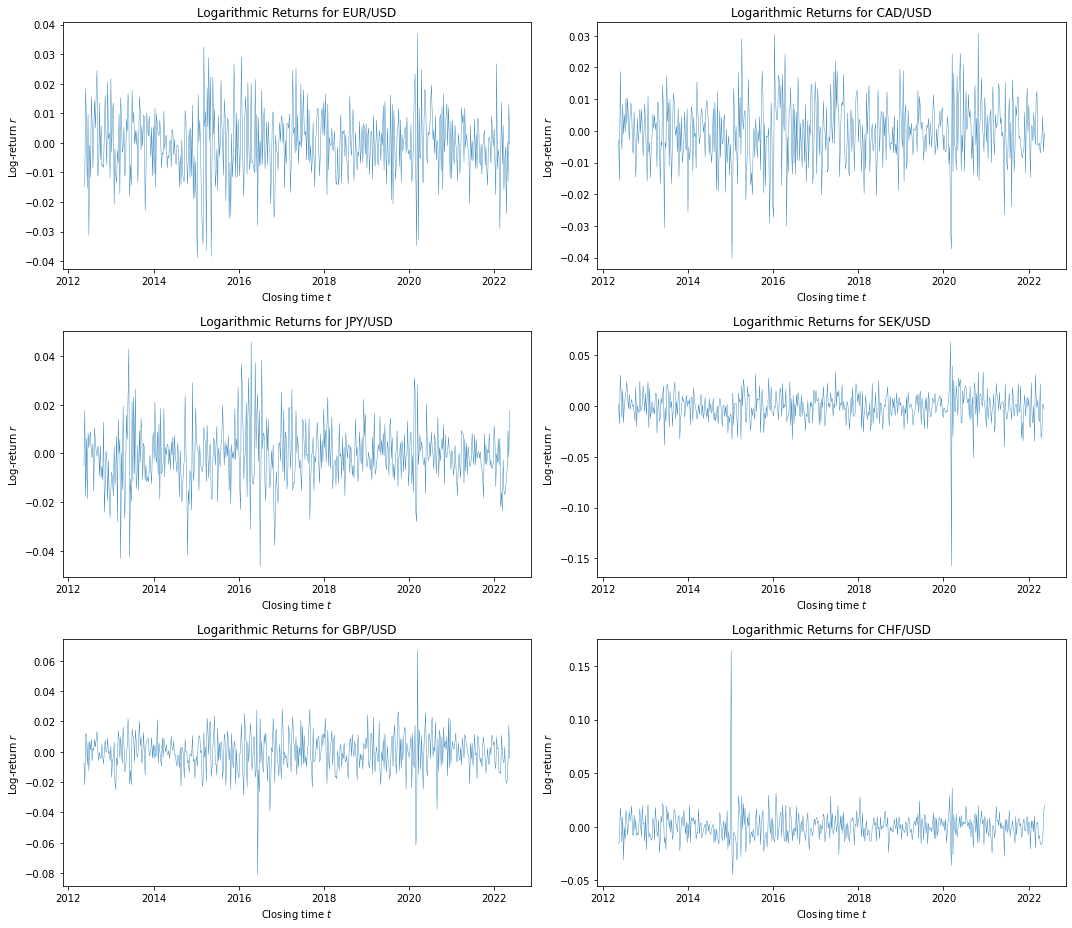

In [202]:
usdx_assets = [
    'EUR',
    'JPY',
    'GBP',
    'CAD',
    'SEK',
    'CHF',
]

usdx = USDX(usdx_assets)
usdx.plot_returns()

In [203]:
usdx.compute_turbulence()
usdx.turbulence

2022-05-16    11.647305
dtype: float64